In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mayavi import mlab
from numba import jit
from tvtk.tools import visual
from scipy import interpolate
import math
from numpy import unravel_index
import pickle
from datalib import Data
from mayavi import mlab
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import healpy as hp
from mpl_toolkits.mplot3d import Axes3D

In [10]:
datadir='.'
data=Data(datadir)
conf = data._conf
#dir = 'multipole_FF/full/'
dir = 'dipole/'
import os
if not os.path.exists(dir):
    os.makedirs(dir)

def cal_PA(vacuum, multipole, h, r_em, point1, minth, maxth, minphi, maxphi):
   
    T = 4.166
    omega = 2*np.pi/T
    c = 3e10
    ini_ph = 0.05*210%(2*np.pi)*180/np.pi
    
    if vacuum:
        if multipole:
            with open("Bx_v.pkl","rb") as f1:
                data_bx = pickle.load(f1)

            with open("By_v.pkl","rb") as f2:
                data_by = pickle.load(f2)
    
            with open("Bz_v.pkl","rb") as f3:
                data_bz = pickle.load(f3)
    
        else:
            with open("Bx_v_dip.pkl","rb") as f1:
                data_bx = pickle.load(f1)

            with open("By_v_dip.pkl","rb") as f2:
                data_by = pickle.load(f2)
    
            with open("Bz_v_dip.pkl","rb") as f3:
                data_bz = pickle.load(f3)
        
    
        w=20
        N1 = len(data_bx)
        x0 = np.linspace(-w,w,N1)
        y0 = np.linspace(-w,w,N1)
        z0 = np.linspace(-w,w,N1)
        center = int(N1/2.0)


    else:
        data_bx = np.transpose(data.Bx,(0,1,2))
        data_by = np.transpose(data.By,(0,1,2))
        data_bz = np.transpose(data.Bz,(0,1,2))
        nz,ny,nx = data_bx.shape
        xmin=conf['lower'][0] 
        ymin=conf['lower'][1]
        zmin=conf['lower'][2]
        sizex=conf['size'][0]
        sizey=conf['size'][1]
        sizez=conf['size'][2]
        xmax=xmin+sizex
        ymax=ymin+sizey
        zmax=zmin+sizez
        dx=sizex/nx
        dy=sizey/ny
        dz=sizez/nz
        x0 = np.linspace(-60,60,nx)
        y0 = np.linspace(-60,60,ny)
        z0 = np.linspace(-60,60,nz)
        center = int(len(data_bx)/2.0)


    n1=200
    n2=200
    th,ph = np.mgrid[minth:maxth:100j, minphi:maxphi:100j]
    xsurf = r_em*np.sin(th)*np.cos(ph)
    ysurf = r_em*np.sin(th)*np.sin(ph)
    zsurf = r_em*np.cos(th)
    
    def field_func():
        Bx = data_bx
        By = data_by
        Bz = data_bz
        Bmag = np.sqrt(Bx**2+By**2+Bz**2)
        Bx = Bx/Bmag
        By = By/Bmag
        Bz = Bz/Bmag
        Bxf=RegularGridInterpolator((z0,y0,x0),Bx)
        Byf=RegularGridInterpolator((z0,y0,x0),By)
        Bzf=RegularGridInterpolator((z0,y0,x0),Bz)
        return Bxf,Byf,Bzf
    


    # calculate field components at the emission radius
    p1 = xsurf.flatten()
    p2 = ysurf.flatten()
    p3 = zsurf.flatten()
    coords=np.stack((p3,p2,p1),axis=-1)
    nx=n1
    Bxf,Byf,Bzf = field_func()
    ez = (Bzf(coords))
    ey = (Byf(coords))
    ex = (Bxf(coords))

    #transform into spherical
    
    thetas = np.arccos(p3/r_em)
    phis = np.arctan2(p2,p1)
    er = np.sin(thetas)*np.cos(phis)*ex + np.sin(thetas)*np.sin(phis)*ey + np.cos(thetas)*ez
    eth = np.cos(thetas)*np.cos(phis)*ex + np.cos(thetas)*np.sin(phis)*ey - np.sin(thetas)*ez
    ephi = -np.sin(phis)*ex + np.cos(thetas)*ey

    
    # remove some noise: opposite emission
    costhetas = (p1*ex + p2*ey + p3*ez)/r_em
    
    th_obs = np.arccos(ez)
    phi0 = -np.arctan2(ey,ex)
    dphi = -((p1*ex + p2*ey + p3*ez)*1e9*omega/c)
    phi_obs = (phi0+dphi)
    
    ids_in = np.where(er<=0.0)[0]
    ids_out = np.where(er>0)[0]
    #ids_in = np.where(costhetas<0)[0]
    
    #plot_points(p1,p2,p3,ex,ey,ez,ids_in,ids_out)
    
    ez[ids_in] = -ez[ids_in]
    ey[ids_in] = -ey[ids_in]
    ex[ids_in] = -ex[ids_in]
    
    
    #plot_points(p1,p2,p3,ex,ey,ez,ids_in,ids_out,r_em)
    
    #computes the emission angles
    
    th_obs = np.arccos(ez)
    
    phi0 = -np.arctan2(ey,ex)
    dphi = -((p1*ex + p2*ey + p3*ez)*1e9*omega/c)
    phi_obs = (phi0)
    
        
    #rotate to make the observer on the x-z plane
    ex1 = ex*np.cos(phi0)-np.sin(phi0)*ey
    ey1 = ex*np.sin(phi0)+np.cos(phi0)*ey
    ez1 = ez
    
    #rotate to make the observer along the z-axis
    deltas = np.arctan(ex1/ez1)
    #ids4 = np.where(deltas<0)[0]
    #deltas[ids4] = deltas[ids4]+np.pi
    
    #rotation about y-axis
    Ex = np.cos(deltas)*ex1 - np.sin(deltas)*ez1
    Ey = ey1
    Ez = np.sin(deltas)*ex1 + np.cos(deltas)*ez1
    

    #calculate field when ray propagates
    xsurf_2 = p1+(h*np.sin(th_obs)*np.cos(-phi0))
    ysurf_2 = p2+(h*np.sin(th_obs)*np.sin(-phi0))
    zsurf_2 = p3+(h*np.cos(th_obs))

    phi_ray = h*1e9/c*omega
    xsurf_p = xsurf_2*np.cos(phi_ray)+np.sin(phi_ray)*ysurf_2
    ysurf_p = -xsurf_2*np.sin(phi_ray)+np.cos(phi_ray)*ysurf_2
    zsurf_p = zsurf_2

    coords_p = np.stack((zsurf_p,ysurf_p,xsurf_p),axis=-1)

    bzp = (Bzf(coords_p))
    byp = (Byf(coords_p))
    bxp = (Bxf(coords_p))

    ### this rotation is required because our initial field is fixed
    b1 = bxp*np.cos(phi_ray)-np.sin(phi_ray)*byp
    b2 = bxp*np.sin(phi_ray)+np.cos(phi_ray)*byp
    b3 = bzp

    # apply same transformations as before
    
    #rotation 1
    
    bx1p = b1*np.cos(phi0)-np.sin(phi0)*b2
    by1p = b1*np.sin(phi0)+np.cos(phi0)*b2
    bz1p = b3
    
    # rotation 2
    
    Bx = np.cos(deltas)*bx1p - np.sin(deltas)*bz1p
    By = by1p
    Bz = np.sin(deltas)*bx1p + np.cos(deltas)*bz1p
    
    
    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3

        
    #ind = np.where(np.logical_and(phi_obs>-360*np.pi/360,phi_obs<-300*np.pi/360.0))[0]
    #ind = np.where(np.logical_and(th_obs>1.7,th_obs<2.5))[0]
    ind = np.where(np.logical_and(th_obs>=0,th_obs<=np.pi))[0]
    #inx = np.where(np.logical_and(phi_obs>-2.9,phi_obs<-300*np.pi/360.0))[0]
    inx = np.where(np.logical_and(phi_obs>=-np.pi,phi_obs<=180*np.pi/180.0))[0]
    intsc = (intersection(ind, inx))
    #print (intsc)
    
    PA = np.arctan(By/Bx)

    grid_th, grid_phi = np.mgrid[min(th_obs):max(th_obs):200j, min(phi_obs):max(phi_obs):200j]
    PA_grid = griddata((th_obs,phi_obs), PA, (grid_th, grid_phi), method='linear')
    
    
    angle1 = np.round(grid_th[:][point1][0]*180/np.pi,2)
    view = np.round(80-angle1,2)
    print ("vacuum = ", vacuum)
    print ("multipole = ", multipole)
    print ("impact angle = "+str(view)+" degrees")
    print ("viewing angle = "+str(angle1)+" degrees")
    print ("emission height = "+str(h)+" R")
    print ("emission radius = "+str(r_em)+" R")


    
    plt.figure(figsize=(6,5))
    plt.contourf(grid_phi*180/np.pi,grid_th*180/np.pi,PA_grid,cmap='Blues')
    plt.xlim(-180,180)
    plt.ylim(0,180)
    plt.axhline(y=angle1, color='k', linestyle='-')
    plt.colorbar(label="PA")    
    plt.ylabel(r'$\theta_{obs}$',size=15)
    plt.xlabel(r'$\phi_{obs}$',size=15)
    plt.title("emission radius = "+str(r_em))
    plt.savefig(dir+'PAgrid_rem_%s.png'%(str(r_em)))
    plt.show()
    
    
    #print (len(p1[ind]),len(p2[ind]),len(p3[ind]))
    
    plot = True
    if plot:
        plt.figure(figsize=(7,5))
        pa1 = PA_grid[:][point1]
        x = np.linspace(min(phi_obs),max(phi_obs),len(grid_th))*180/np.pi
        plt.scatter(x,pa1*180/np.pi,label=view,c='k',s=10)
        np.savetxt(dir+'PA_curve_RT_rem_%s_view_%s.txt'%(str(r_em),str(angle1)),np.c_[x,pa1*180/np.pi])
        plt.xlabel(r'$\phi_{obs}$ [deg]',size=20)
        plt.ylabel(r'$PA$ [deg]',size=20)
        plt.legend()
        plt.title("emission radius = "+str(r_em))
        plt.savefig(dir+'PA_curve_RT_rem_%s_view_%s.png'%(str(r_em),str(angle1)))
        plt.show()
    
    return grid_th, grid_phi, PA_grid, th_obs[intsc], phi_obs[intsc], p1[intsc], p2[intsc], p3[intsc], er

/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_77526/183040441.py:82: RuntimeWarning: invalid value encountered in true_divide
  Bx = Bx/Bmag
/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_77526/183040441.py:83: RuntimeWarning: invalid value encountered in true_divide
  By = By/Bmag
/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_77526/183040441.py:84: RuntimeWarning: invalid value encountered in true_divide
  Bz = Bz/Bmag


vacuum =  True
multipole =  False
impact angle = 10.28 degrees
viewing angle = 69.72 degrees
emission height = 0.1 R
emission radius = 4 R


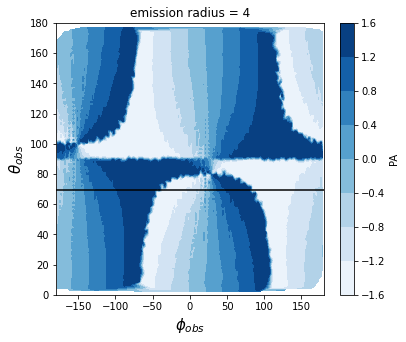

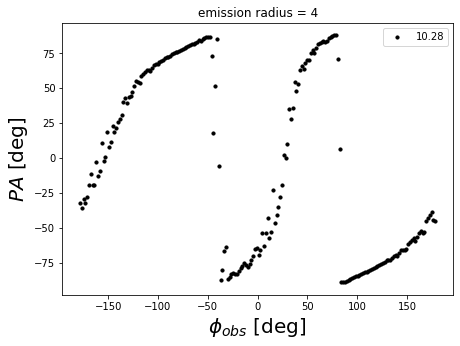

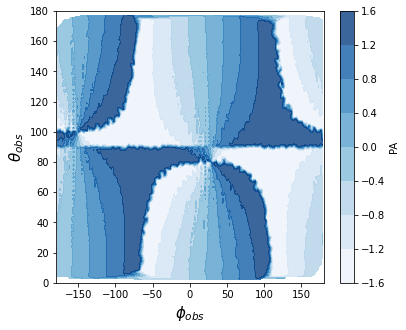

In [11]:
## 1st argument = vacuum, 
## 2nd argument = multipole, 
## 3rd argument = height (R), 
## 4th argument = emission_rad (R), 
## view = index
t1,p1,pa1,to1,po1,p11,p21,p31, er1 = cal_PA(True, False, 0.1, 4, 77, 0*np.pi/180, 180*np.pi/180, -180*np.pi/180, 180*np.pi/180)
#t2,p2,pa2,to2,po2,p12,p22,p32, er2 = cal_PA(False, False, 1, 3, 120, 90*np.pi/180, 180*np.pi/180, -180*np.pi/180.0, -160*np.pi/180)
plt.figure(figsize=(6,5))
plt.contourf(p1*180/np.pi,t1*180/np.pi,pa1,cmap='Blues',alpha=0.8)
#plt.contourf(p2*180/np.pi,t2*180/np.pi,pa2,colors='g',alpha=0.2)
plt.xlim(-180,180)
plt.ylim(0,180)
plt.colorbar(label="PA")    
plt.ylabel(r'$\theta_{obs}$',size=15)
plt.xlabel(r'$\phi_{obs}$',size=15)
#plt.savefig(dir+"PA_skymap.png")
plt.show()

NameError: name 'po2' is not defined

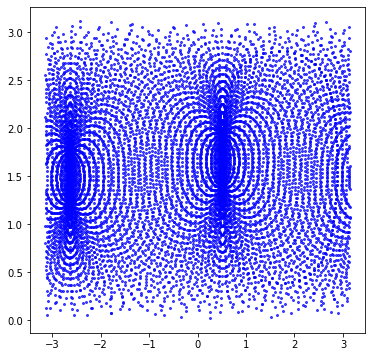

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(po1,to1,c='b',alpha=0.7,label=r'$\theta$ ='+str(0)+'-'+str(90)+r',$\phi$='+str(0)+'-'+str(180),s=4)
plt.scatter(po2,to2,c='r',alpha=0.7,label=r'$\theta$ ='+str(90)+'-'+str(180)+r',$\phi$='+str(180)+'-'+str(360),s=4)
plt.xlabel(r'$\phi_{obs}$',size=20)
plt.ylabel(r'$\theta_{obs}$',size=20)
#plt.legend(loc='best',fontsize=10)
#plt.savefig('overlap1.png')
plt.show()

In [ ]:
def cal_field(vacuum, multipole):
   
    T = 4.166
    omega = 2*np.pi/T
    c = 3e10
    ini_ph = 0.05*210%(2*np.pi)*180/np.pi
    
    if vacuum:
        if multipole:
            with open("Bx_v.pkl","rb") as f1:
                data_bx = pickle.load(f1)

            with open("By_v.pkl","rb") as f2:
                data_by = pickle.load(f2)
    
            with open("Bz_v.pkl","rb") as f3:
                data_bz = pickle.load(f3)
    
        else:
            with open("Bx_v_dip.pkl","rb") as f1:
                data_bx = pickle.load(f1)

            with open("By_v_dip.pkl","rb") as f2:
                data_by = pickle.load(f2)
    
            with open("Bz_v_dip.pkl","rb") as f3:
                data_bz = pickle.load(f3)
        
    
        w=20
        N1 = len(data_bx)
        x0 = np.linspace(-w,w,N1)
        y0 = np.linspace(-w,w,N1)
        z0 = np.linspace(-w,w,N1)
        center = int(N1/2.0)


    else:
        data_bx = np.transpose(data.Bx,(0,1,2))
        data_by = np.transpose(data.By,(0,1,2))
        data_bz = np.transpose(data.Bz,(0,1,2))
        nz,ny,nx = data_bx.shape
        xmin=conf['lower'][0] 
        ymin=conf['lower'][1]
        zmin=conf['lower'][2]
        sizex=conf['size'][0]
        sizey=conf['size'][1]
        sizez=conf['size'][2]
        xmax=xmin+sizex
        ymax=ymin+sizey
        zmax=zmin+sizez
        dx=sizex/nx
        dy=sizey/ny
        dz=sizez/nz
        x0 = np.linspace(-60,60,nx)
        y0 = np.linspace(-60,60,ny)
        z0 = np.linspace(-60,60,nz)
        center = int(len(data_bx)/2.0)

    
    
    Bx = data_bx
    By = data_by
    Bz = data_bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    Bx = Bx/Bmag
    By = By/Bmag
    Bz = Bz/Bmag
    Bxf=RegularGridInterpolator((z0,y0,x0),Bx)
    Byf=RegularGridInterpolator((z0,y0,x0),By)
    Bzf=RegularGridInterpolator((z0,y0,x0),Bz)
             
    return Bxf,Byf,Bzf

In [ ]:
Bxf, Byf, Bzf = cal_field(False, False)

In [ ]:
def numerically_find_flow_line_3d(starting_point, step):
    func_x = []
    func_y = []
    func_z = []
    
    x = starting_point[0]
    y = starting_point[1]
    z = starting_point[2]
    
    edge = 20
    
    while True:
        func_x.append(x)
        func_y.append(y)
        func_z.append(z)
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x + delta_x
        y = y + delta_y
        z = z + delta_z
        r = np.sqrt(x**2+y**2+z**2)
        if x>edge or x<-edge or y>edge or y<-edge or z>edge or z<-edge or np.isnan(x) or np.isnan(y) or np.isnan(z) or r<2:
            break
       
    while True:
        func_x.append(x)
        func_y.append(y)
        func_z.append(z)
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x - delta_x
        y = y - delta_y
        z = z - delta_z
        r = np.sqrt(x**2+y**2+z**2)
        if x>edge or x<-edge or y>edge or y<-edge or z>edge or z<-edge or np.isnan(x) or np.isnan(y) or np.isnan(z) or r<2:
        #if r<6 or np.isnan(r):
            break
    
    return func_x, func_y, func_z

In [ ]:
def openfieldlines(starting_point, step, opfl):
    func_x = []
    func_y = []
    func_z = []
    
    x = starting_point[0]
    y = starting_point[1]
    z = starting_point[2]
    
    edge = 20
    
    while True:
        func_x.append(x)
        func_y.append(y)
        func_z.append(z)
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x + delta_x
        y = y + delta_y
        z = z + delta_z
        r = np.sqrt(x**2+y**2+z**2)
        if r>edge:
            #print (r, starting_point)
            opfl.append([starting_point])
            break
        if r<2.0:
            break
            
    while True:
        func_x.append(x)
        func_y.append(y)
        func_z.append(z)
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x - delta_x
        y = y - delta_y
        z = z - delta_z
        r = np.sqrt(x**2+y**2+z**2)
        if r>edge:
            #print (r,starting_point)
            opfl.append([starting_point])
            break
        if r<2.0:
            break
    
    return opfl

In [ ]:
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]

r = 2.0
x = r*sin(phi)*cos(theta) 
y = r*sin(phi)*sin(theta)
z = r*cos(phi)
p1 = x.flatten()
p2 = y.flatten()
p3 = z.flatten()
coords1=np.stack((p3,p2,p1),axis=-1)
bz = (Bzf(coords1))
by = (Byf(coords1))
bx = (Bxf(coords1))


mlab.figure(1, bgcolor=(0, 0, 0), fgcolor=(0, 0, 0), size=(800, 800))
mlab.clf()

rr = 2.0
phi, theta = np.mgrid[0*pi/180:180*pi/180:10j, 0.0:2.0*pi:10j]
x1 = rr*sin(phi)*cos(theta) 
y1 = rr*sin(phi)*sin(theta)
z1 = rr*cos(phi)
pp1 = x1.flatten()
pp2 = y1.flatten()
pp3 = z1.flatten()


opfl = []

mlab.mesh(x,y,z,opacity=0.7,color=(0.176, 0.521, 0.941))
#mlab.points3d(p11, p21, p31, scale_factor=0.05, color=(1,0,0))
#mlab.points3d(p12, p22, p32, scale_factor=0.05, color=(0,0,1))

rrl = 2.0
phi, theta = np.mgrid[0*pi/180:180*pi/180:200j, 0.0:2.0*pi:200j]
x11 = rrl*sin(phi)*cos(theta) 
y11 = rrl*sin(phi)*sin(theta)
z11 = rrl*cos(phi)
ppp1 = x11.flatten()
ppp2 = y11.flatten()
ppp3 = z11.flatten()

for i in range(40000):
    opfl = openfieldlines((ppp1[i],ppp2[i],ppp3[i]), 0.2, opfl)

xpo,ypo,zpo = [],[],[]
for i in range(len(opfl)):
    xpo.append(opfl[i][0][0])
    ypo.append(opfl[i][0][1])
    zpo.append(opfl[i][0][2])

mlab.points3d(xpo, ypo, zpo, scale_factor=0.1, color=(1,0,0))


for i in range(100):
    fx1,fy1,fz1 = numerically_find_flow_line_3d((pp1[i],pp2[i],pp3[i]), 0.2)
    mlab.plot3d(fx1, fy1, fz1, line_width=2.5, tube_radius=0.05, color=(1,1,1))
    #fx2,fy2,fz2 = numerically_find_flow_line_3d((np1[i],np2[i],np3[i]), 0.2)
    #mlab.plot3d(fx2, fy2, fz2, line_width=2.5, tube_radius=0.05, color=(1,1,1))

mlab.show()

In [ ]:
xpo = np.array(xpo)
ypo = np.array(ypo)
zpo = np.array(zpo)
print (len(xpo))

In [ ]:
np.savetxt("FF_polar_points.txt",np.c_[xpo,ypo,zpo])